In [1]:
# standard libraries
import pandas as pd
import numpy as np
import time
import re #regex

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# data pre-processing
from sklearn.preprocessing import StandardScaler
#from sklearn import preprocessing

# prediction models
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import metrics as mt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

### df_mat EDA

In [3]:
df_mat = pd.read_csv('superconduct/unique_m.csv') 

In [4]:
df_mat.shape

(21263, 88)

In [5]:
df_mat.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [6]:
df_mat['critical_temp'].describe() 
# Heavily right-skewed response variable

count    21263.000000
mean        34.421219
std         34.254362
min          0.000210
25%          5.365000
50%         20.000000
75%         63.000000
max        185.000000
Name: critical_temp, dtype: float64

<AxesSubplot:xlabel='critical_temp', ylabel='Count'>

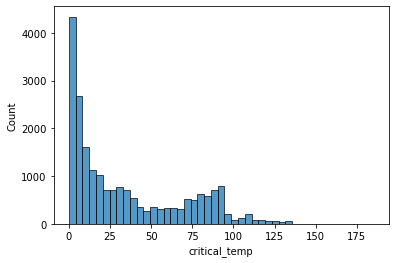

In [7]:
sns.histplot(df_mat['critical_temp'])
# Multi-modal as well with second peak at 75-90

<AxesSubplot:xlabel='critical_temp', ylabel='Count'>

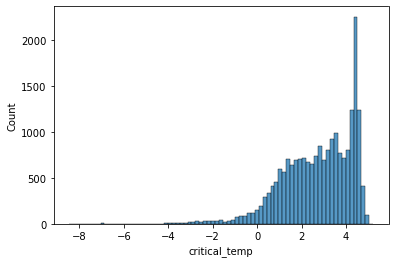

In [8]:
sns.histplot( np.log(df_mat['critical_temp']) ) 
# Not lognormal either...

In [9]:
mat_desc = df_mat.describe().T
mat_desc.tail()
# Some variables have all zeroes - no information (Po, At, Rn)

,count,mean,std,min,25%,50%,75%,max
Bi,21263.0,0.201009,0.655927,0.00000,0.000,0.0,0.0,14.0
Po,21263.0,0.000000,0.000000,0.00000,0.000,0.0,0.0,0.0
At,21263.0,0.000000,0.000000,0.00000,0.000,0.0,0.0,0.0
Rn,21263.0,0.000000,0.000000,0.00000,0.000,0.0,0.0,0.0
critical_temp,21263.0,34.421219,34.254362,0.00021,5.365,20.0,63.0,185.0


In [9]:
# Elements not present in any superconductors, all 0s
zero_elem = mat_desc.loc[mat_desc['mean']==0] 
zero_elem

,count,mean,std,min,25%,50%,75%,max
He,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ne,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ar,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kr,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Xe,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pm,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Po,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
At,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rn,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Drop all elements that contain no information - will cause high VIF with modeling

drop_col = zero_elem.T.columns # Get the column names to drop
df_mat.drop(drop_col, axis=1, inplace=True)

In [11]:
df_mat.head() # Removed 9 elements

,H,Li,Be,B,C,N,O,F,Na,Mg,...,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,critical_temp,material
0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,Ba0.3La1.7Cu1O4


### df_train EDA

In [12]:
df_train = pd.read_csv('train.csv') 

In [13]:
df_train.shape

(21263, 82)

In [14]:
df_train.head()
# Lots of redundant summary stats in this table

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [15]:
train_names = list(df_train.columns)

# regex to only keep wtd_mean... as summary stats from df_train
m = re.compile('wtd_mean|crit')
col_match = [m.match(i) for i in train_names]
col_names = [x for i,x in zip(col_match, train_names) if i!=None]

In [16]:
df_train[col_names].head()

,wtd_mean_atomic_mass,wtd_mean_fie,wtd_mean_atomic_radius,wtd_mean_Density,wtd_mean_ElectronAffinity,wtd_mean_FusionHeat,wtd_mean_ThermalConductivity,wtd_mean_Valence,critical_temp
0,57.862692,1010.268571,105.514286,2961.502286,111.727143,3.846857,61.015189,2.257143,29.0
1,58.518416,1010.612857,104.971429,3021.016571,112.316429,3.796857,61.372331,2.257143,26.0
2,57.885242,1010.820000,104.685714,2999.159429,112.213571,3.822571,60.943760,2.271429,19.0
3,57.873967,1010.544286,105.100000,2980.330857,111.970357,3.834714,60.979474,2.264286,22.0
4,57.840143,1009.717143,106.342857,2923.845143,111.240714,3.871143,61.086617,2.242857,23.0


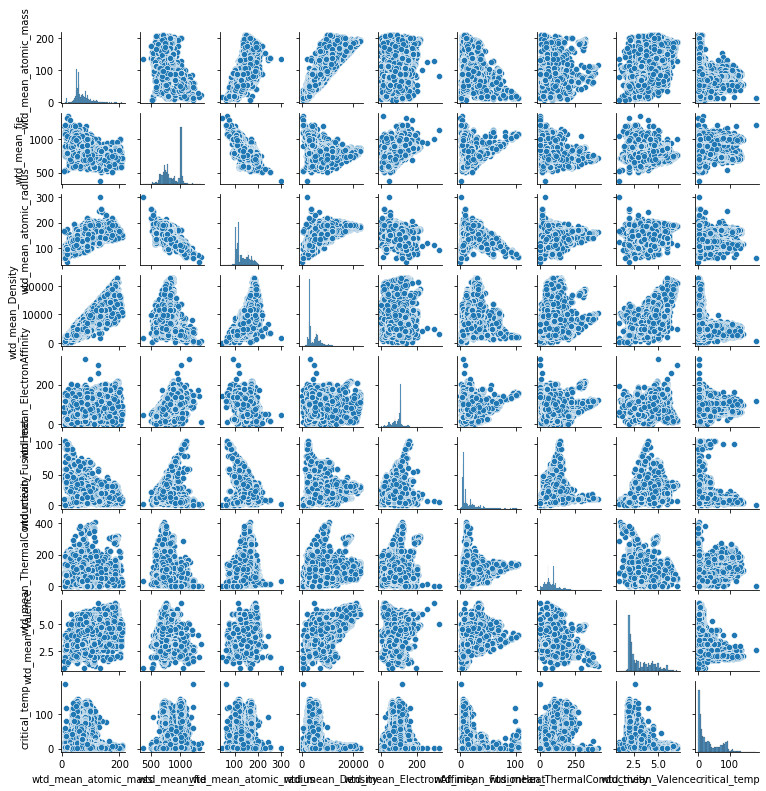

In [17]:
sns.pairplot(df_train[col_names], height=1.2)

## Visual correlation between wtd_mean_atomic_fie & wtd_mean_atomic_radius
## There appears to be a general lack of correlation between the explanatory variables and the response (bottom row)

In [18]:
temp_match = df_mat['critical_temp'] == df_train['critical_temp']
temp_match.describe()
# The 2 dataframes match for critical temp values for all rows and can likely be merged together

count     21263
unique        1
top        True
freq      21263
Name: critical_temp, dtype: object

In [19]:
col_names.pop()

'critical_temp'

In [20]:
# Define y and X

y = np.array( df_train['critical_temp'] )

df_mat.drop(['critical_temp', 'material'], axis=1, inplace=True)
df_train.drop(['critical_temp'], axis=1, inplace=True)

X = pd.concat([df_mat, df_train], axis=1)

In [21]:
X.head()

,H,Li,Be,B,C,N,O,F,Na,Mg,...,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence
0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.25,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059
1,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.00,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606
2,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.25,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697
3,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.25,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952
4,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.25,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809


In [22]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234321) 

# Center and Scale X
scl = StandardScaler()
scl.fit(X_train)
X_train_scaled = scl.transform(X_train) # apply to training
X_test_scaled = scl.transform(X_test) # apply to the test set (without snooping)

In [23]:
L1 = Lasso(alpha = 1.0)

# Cross validation on training set
L1_CV_RMSE = cross_validate(L1, X_train_scaled, y_train, cv = 5, scoring='neg_root_mean_squared_error')['test_score']
L1_CV_RMSE = [round(-i,2) for i in L1_CV_RMSE]
print( "Lasso CV 5 Folds RMSE =", L1_CV_RMSE )

y_hat = cross_val_predict(L1, X_train_scaled, y_train, cv = 5)
L1_RMSE = mse(y_train, y_hat, squared=False)
print( "Lasso CV RMSE =", round(L1_RMSE,2) )

L1_Rsq = r2_score(y_train, y_hat)
print( "\nLasso CV R-squared =", round(L1_Rsq,3) )

## Baseline model performance?

Lasso CV 5 Folds RMSE = [18.9, 18.72, 18.69, 19.58, 18.61]
Lasso CV RMSE = 18.9

Lasso CV R-squared = 0.697


In [24]:
L2 = Ridge(alpha = 1.0)

# Cross validation on training set
L2_CV_RMSE = cross_validate(L2, X_train_scaled, y_train, cv = 5, scoring='neg_root_mean_squared_error')['test_score']
L2_CV_RMSE = [round(-i,2) for i in L2_CV_RMSE]
print("Ridge CV 5 Folds RMSE =", L2_CV_RMSE)

y_hat = cross_val_predict(L2, X_train_scaled, y_train, cv = 5)
L2_RMSE = mse(y_train, y_hat, squared=False)
print( "Ridge CV RMSE =", round(L2_RMSE,2) )

L2_Rsq = r2_score(y_train, y_hat)
print( "\nRidge CV R-squared =", round(L2_Rsq,3) )

## First fold is performing poorly with high RMSE - too many terms in model

Ridge CV 5 Folds RMSE = [29.16, 16.89, 16.62, 17.26, 16.12]
Ridge CV RMSE = 19.85

Ridge CV R-squared = 0.666


### Tune alpha for Ridge to improve CV.  
Increasing alpha increases the penalty and prevents overfitting.

In [25]:
Ridge_df = []

for i in [10,100,500,1000]:
    L2 = Ridge(alpha =i )
    
    # Cross validation on training set
    L2_Rsq = cross_validate(L2, X_train_scaled, y_train, cv = 5, scoring='neg_root_mean_squared_error')['test_score']
    CV_1st_fold_RMSE = round(-L2_Rsq[0],2)
    
    y_hat = cross_val_predict(L2, X_train_scaled, y_train, cv = 5)
    CV_RMSE = round(mse(y_train, y_hat, squared=False), 2)
    
    CV_Rsq = round( r2_score(y_train, y_hat) ,3)
    
    Ridge_df.append([ i, CV_1st_fold_RMSE, CV_RMSE, CV_Rsq ])
    
Ridge_df = pd.DataFrame(Ridge_df, columns = ['Ridge alpha', 'CV 1st Fold RMSE', 'CV RMSE', 'CV R-squared'])
Ridge_df

,Ridge alpha,CV 1st Fold RMSE,CV RMSE,CV R-squared
0,10,27.17,19.32,0.684
1,100,19.93,17.69,0.735
2,500,17.90,17.52,0.740
3,1000,17.94,17.69,0.735


### Tune alpha for LASSO to improve model.  
Decreasing alpha decreases the penalty and adds more model terms (higher variance, lower bias).

In [26]:
Lasso_df = []

for i in [0.06, 0.1, 0.5]:
    L1 = Lasso(alpha = i)
  
    # Cross validation on training set
    L1_Rsq = cross_validate(L1, X_train_scaled, y_train, cv = 5, scoring='neg_root_mean_squared_error')['test_score']
    CV_1st_fold_RMSE = round(-L1_Rsq[0],2)
    
    y_hat = cross_val_predict(L1, X_train_scaled, y_train, cv = 5)
    CV_RMSE = round(mse(y_train, y_hat, squared=False), 2)
    
    CV_Rsq = round(r2_score(y_train, y_hat),3)
    
    Lasso_df.append([ i, CV_1st_fold_RMSE, CV_RMSE, CV_Rsq ])
    
Lasso_df = pd.DataFrame(Lasso_df, columns = ['Lasso alpha', 'CV 1st Fold RMSE', 'CV RMSE', 'CV R-squared'])
Lasso_df

## alpha = 0.06 is the best & lowest CV value without getting a convergence error

,Lasso alpha,CV 1st Fold RMSE,CV RMSE,CV R-squared
0,0.06,17.47,17.26,0.748
1,0.10,17.58,17.44,0.742
2,0.50,18.28,18.24,0.718


### Run "final" model with Lasso

In [27]:
L1 = Lasso(alpha = 0.06)
L1.fit(X_train_scaled, y_train)

y_hat_train = L1.predict(X_train_scaled)
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "Lasso Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "Lasso Training R-Sq =", round(Rsq,3) )

y_hat_test = L1.predict(X_test_scaled)
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nLasso Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "Lasso Test R-Sq =", round(Rsq,3) )

## Model is NOT generalizable with alpha = 0.06, need to increase alpha

Lasso Training RMSE = 17.03
Lasso Training R-Sq = 0.754

Lasso Test RMSE = 28.46
Lasso Test R-Sq = 0.3


### Final Lasso Model - Tested

In [28]:
L1 = Lasso(alpha = 3.0)
L1.fit(X_train_scaled, y_train)

y_hat_train = L1.predict(X_train_scaled)
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "Lasso Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "Lasso Training R-Sq =", round(Rsq,3) )

y_hat_test = L1.predict(X_test_scaled)
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nLasso Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "Lasso Test R-Sq =", round(Rsq,3) )

model_coef = pd.DataFrame(zip(X.columns, L1.coef_), columns=['Factor','Coef'])
model_factors = model_coef[model_coef['Coef']!=0]

print("\nKept Factors(", model_factors.shape[0], "of", X.shape[1],"):")
model_coef[model_coef['Coef']!=0]

Lasso Training RMSE = 20.66
Lasso Training R-Sq = 0.639

Lasso Test RMSE = 20.65
Lasso Test R-Sq = 0.631

Kept Factors( 14 of 158 ):


,Factor,Coef
16,Ca,3.071438
50,Ba,6.199355
73,Hg,0.574007
76,Bi,0.639824
77,number_of_elements,0.339930
83,wtd_entropy_atomic_mass,2.974902
84,range_atomic_mass,0.637915
94,range_fie,1.056033
104,range_atomic_radius,2.066270
120,gmean_ElectronAffinity,-1.877815


### Try adding 2-way interactions with kept model terms

In [29]:
from sklearn.preprocessing import PolynomialFeatures

# Create interaction terms
intx = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X.columns)

model_terms = list(model_factors['Factor'])

X_intx_train = pd.DataFrame( intx.fit_transform(X_train_scaled[model_terms]) )
X_intx_test = pd.DataFrame( intx.fit_transform(X_test_scaled[model_terms]) )

Source for adding interactions: https://chrisalbon.com/code/machine_learning/linear_regression/adding_interaction_terms/#:~:text=%23%20Create%20interaction%20term%20%28not%20polynomial%20features%29%20interaction,Fit%20the%20linear%20regression%20model%20%3D%20regr.fit%28X_inter%2C%20y%29

In [30]:
X_intx_train.head()

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,-0.288548,1.448323,-0.184255,-0.303685,0.612949,0.667673,0.104198,0.768867,0.976478,0.157916,...,0.102641,0.167170,-0.121218,0.044576,0.688061,-0.498925,0.183473,-0.812595,0.298822,-0.216681
1,-0.288548,0.941437,-0.184255,-0.303685,0.612949,0.791791,0.230928,0.768867,0.976478,-0.038064,...,0.012967,-0.056903,0.029943,0.021840,-0.509272,0.267988,0.195464,-1.175971,-0.857723,0.451349
2,-0.288548,-0.579221,-0.184255,-0.303685,-0.778302,-0.316077,-0.068142,-1.272765,-0.929996,0.279665,...,-0.087962,-0.021523,0.200010,0.454006,0.024205,-0.224941,-0.510599,-0.055039,-0.124933,1.161010
3,-0.288548,-0.579221,-0.184255,2.740528,0.612949,0.604798,1.417381,0.691038,0.887112,0.048495,...,0.010050,0.012959,-0.022232,0.053102,0.055378,-0.095002,0.226918,-0.122506,0.292614,-0.501983
4,-0.288548,-0.579221,-0.184255,-0.303685,-1.473928,-1.273630,-1.527568,-1.531118,-1.272566,-0.052332,...,0.038303,0.049363,-0.037426,0.077023,0.690418,-0.523462,1.077276,-0.674610,1.388336,-1.052609


In [31]:
L1 = Lasso(alpha = 3.0)
L1.fit(X_intx_train, y_train)

y_hat_train = L1.predict(X_intx_train)
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "Lasso Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "Lasso Training R-Sq =", round(Rsq,3) )

y_hat_test = L1.predict(X_intx_test)
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nLasso Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "Lasso Test R-Sq =", round(Rsq,3) )

print("\nAdded", len(L1.coef_[L1.coef_!=0]) - model_factors.shape[0], 
      "two-way interaction terms that improved the model prediction") 

Lasso Training RMSE = 19.35
Lasso Training R-Sq = 0.683

Lasso Test RMSE = 19.28
Lasso Test R-Sq = 0.678

Added 4 two-way interaction terms that improved the model prediction
